# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
os.environ["CUDA_VISIBLE_DEVICES"]='3,4'
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

#%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class RSConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "RS"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 8  # background + 8 classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = RSConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
#LABEL1 = np.load('/disk5/zhangyunfeng/RS/RS_Fusion_Exp/Data/labels/image_1.npz')

In [5]:
#LABEL1['images'].shape

(210, 4, 256, 256)

In [6]:
#LABEL1['masks'][0].shape

(7, 256, 256)

In [7]:
#LABEL1['labels'][0].shape

(7,)

In [8]:
class RSDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    counter = 0
    
    def load_RS(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("RS", 1, "Roads")
        self.add_class("RS", 2, "Buildings")
        self.add_class("RS", 3, "Trees")
        self.add_class("RS", 4, "Grass")
        self.add_class("RS", 5, "Bare Soil")
        self.add_class("RS", 6, "Water")
        self.add_class("RS", 7, "Railways")
        self.add_class("RS", 8, "Swimming Pools")
        
        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        
        for i in range(count):
            subimg_path = '/disk5/zhangyunfeng/RS/RS_Fusion_Exp/Data/labels/image_%s.npz' % (i+1)
            subimgs = np.load(subimg_path)
            imgs = subimgs['images']
            masks = subimgs['masks']
            bboxes = subimgs['bboxes']
            labels = subimgs['labels']
            n_imgs = imgs.shape[0]
            for j in range(n_imgs):
                img = imgs[j] # 4*224*224
                # 去除近红外通道
                img = img[:3, :, :]
                # 原顺序为channel,width,height，调整为widith,height,channel
                img = np.transpose(img,(1, 2, 0))
                mask = masks[j] # n_instances*224*224
                mask = np.transpose(mask,(1, 2, 0))
                bbox = bboxes[j] # n_instances*4 
                label = labels[j] # n_instances
                image_id = RSDataset.counter
                RSDataset.counter += 1
                instances = []
                for k in range(label.shape[0]):                    
                    instances.append((self.class_info[label[k]]['name'], bbox[k]))
                self.add_image("RS", image_id=RSDataset.counter, path=None,
                               width=width, height=height,
                               instances=instances, mask=mask, class_id=label, img=img)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        image = info['img']
        return image
    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "RS":
            return info["RS"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        mask = info['mask']
        class_ids = info['class_id']
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [9]:
# Training dataset
dataset_train = RSDataset()
print(dataset_train.counter)
dataset_train.load_RS(3, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

0


In [10]:
print(dataset_train.counter)

391

In [11]:
# Validation dataset
dataset_val = RSDataset()
dataset_val.load_RS(1, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [12]:
print(dataset_val.counter)

601

(256, 256, 3)


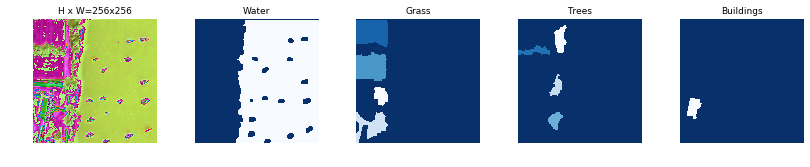

(256, 256, 13) (13,)


array([4, 3, 4, 1, 5, 2, 4, 4, 4, 3, 3, 3, 6], dtype=int32)

In [13]:
# Load and display random samples
image_id = np.random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
print(image.shape)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
print(mask.shape, class_ids.shape)
class_ids

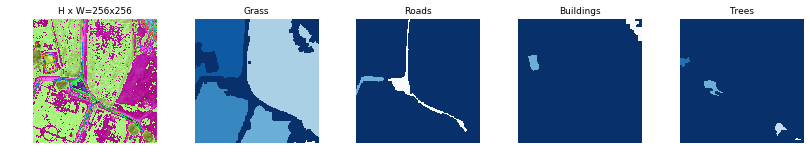

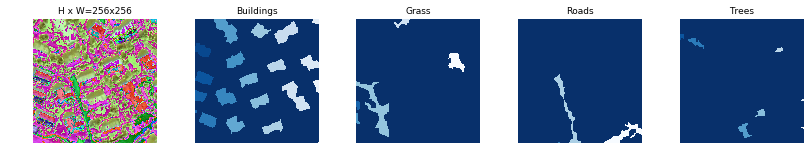

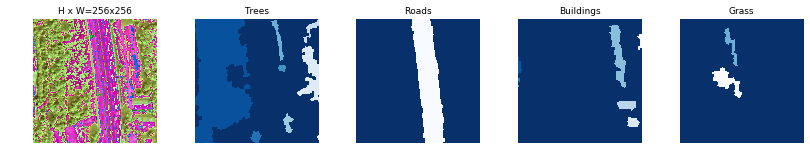

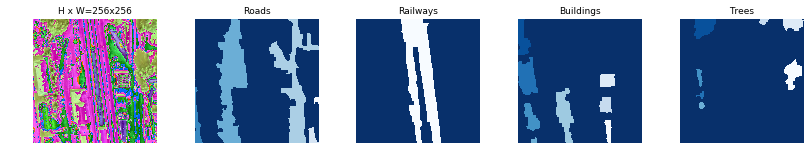

In [14]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [16]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [17]:
#%%time
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /disk5/zhangyunfeng/RS/RS_Fusion_Exp/Model/Mask_RCNN-master/logs/rs20181023T1950/mask_rcnn_rs_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4     

/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/root/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 81s 809ms/step - loss: 3.4208 - rpn_class_loss: 0.2228 - rpn_bbox_loss: 1.1305 - mrcnn_class_loss: 0.7395 - mrcnn_bbox_loss: 0.7092 - mrcnn_mask_loss: 0.6188 - val_loss: 3.0230 - val_rpn_class_loss: 0.1358 - val_rpn_bbox_loss: 1.0710 - val_mrcnn_class_loss: 0.6719 - val_mrcnn_bbox_loss: 0.5945 - val_mrcnn_mask_loss: 0.5498
CPU times: user 3min 14s, sys: 46.2 s, total: 4min
Wall time: 2min 52s


In [18]:
# model.summary()

AttributeError: 'MaskRCNN' object has no attribute 'summary'

In [19]:
#%%time
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /disk5/zhangyunfeng/RS/RS_Fusion_Exp/Model/Mask_RCNN-master/logs/rs20181023T1950/mask_rcnn_rs_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branc

/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/root/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2
100/100 [==============================] - 127s 1s/step - loss: 2.8783 - rpn_class_loss: 0.1463 - rpn_bbox_loss: 1.0590 - mrcnn_class_loss: 0.5972 - mrcnn_bbox_loss: 0.5472 - mrcnn_mask_loss: 0.5285 - val_loss: 2.7453 - val_rpn_class_loss: 0.1332 - val_rpn_bbox_loss: 0.9602 - val_mrcnn_class_loss: 0.5989 - val_mrcnn_bbox_loss: 0.5301 - val_mrcnn_mask_loss: 0.5230
CPU times: user 3min 37s, sys: 59.4 s, total: 4min 36s
Wall time: 3min 12s


In [20]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [21]:
class InferenceConfig(RSConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /disk5/zhangyunfeng/RS/RS_Fusion_Exp/Model/Mask_RCNN-master/logs/rs20181023T1950/mask_rcnn_rs_0002.h5
Re-starting from epoch 2


original_image           shape: (256, 256, 3)         min:    0.00000  max:  900.00000  uint16
image_meta               shape: (21,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (10,)                 min:    1.00000  max:    7.00000  int32
gt_bbox                  shape: (10, 4)               min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  bool


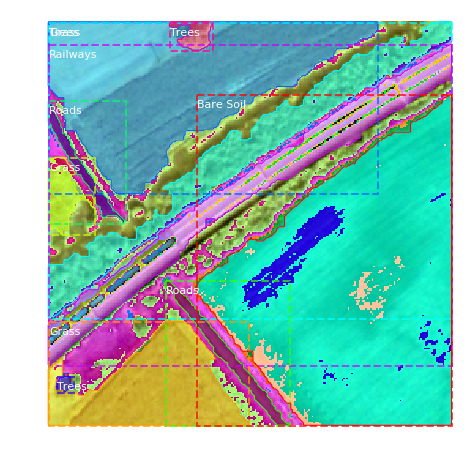

In [22]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  900.00000  uint16
molded_images            shape: (1, 256, 256, 3)      min: -116.80000  max:  783.20000  float64
image_metas              shape: (1, 21)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


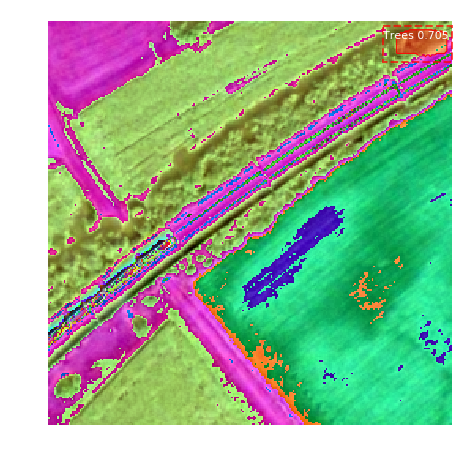

In [23]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [24]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.1357650573852688
